In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from IPython.display import Markdown as md
import cosmology_plots as co_pl

os.chdir('..')
import cosmology as co
import plot_sets
os.chdir('cosmology')

### We solve Friedmann equations to obtain $\eta$, $a$, ${\cal H}$, $a''/a$ that is required by the Pencil Code to solve the GW equation over cosmological simulations.

### The notebook cosmology.ipynb includes detailed calculations and information on Friedmann equations and the solver.

In [2]:
# Constants of the model
OmL0 = 0.6841      # Dark energy density as a fraction of present-time critical energy density
h0 = 0.6732        # Hubble rate H0 = 100 h0 km/s/Mpc
Neff = 3.          # effective number of neutrino species

# directory where to read the file for variation of dofs during RD era
dir0 = '../'

# Array of scale factors
a = np.logspace(-20, 2, 10000)

# Use Friedmann solver to compute the cosmic and conformal time as functions of the scale
# factor a
t, eta, Om_tot, Om_rad, Om_matt, w, ad, add, ap, app = \
        co.friedmann_solver(a, a0=1., h0=h0, OmL0=OmL0, dir0=dir0, return_all=True,
                            dofs=True, Neff=Neff, save=True)

Entering Friedmann solver
The results are saved in the file friedmann/solution.csv
The input parameters used are stored in friedmann/README.txt
Leaving Friedmann solver


In [14]:
### For the Pencil Code, we generate an array of conformal times eta
### that are equidistant in logspace

etas_n = np.logspace(np.log10(eta[1].value), np.log10(eta[-1].value), 10000)
a_n = np.interp(etas_n, eta.value, a)
H_n = np.interp(etas_n, eta.value, ap.value/a)
Hpp_n = np.interp(etas_n, eta.value, app.value/a)

#### cut the values at small a that have some numerical artifacts
#### from the initial conditions
#### we take a > 1e-18
a_good = a_n[np.where(a_n >= 1e-18)]
eta_good = etas_n[np.where(a_n >= 1e-18)]
Hp_good = H_n[np.where(a_n >= 1e-18)]
Hpp_good = Hpp_n[np.where(a_n >= 1e-18)]

In [37]:
#### Write file that is read by the Pencil Code
# First line contains some info used to interpolate values within the
# the Pencil Code
# Rest of lines contain eta, a, a'/a and a''/a

H0 = h0*100*u.km/u.s/u.Mpc
H0 = H0.to(u.Hz)

with open('friedmann/a_vs_eta.dat', 'w') as f:
    f.write('%i, %.15f, %.15f, %.15e, %.4f \n'%(len(eta_good), np.log10(eta_good[0]), 
                               np.log10(eta_good[1]/eta_good[0]), H0.value, 1-OmL0))
    for i in range(0, len(a_good)):
        f.write('%.15e %.15e %.15e %.15e \n'%(eta_good[i], a_good[i],
                                              Hp_good[i], Hpp_good[i]))

1e-20


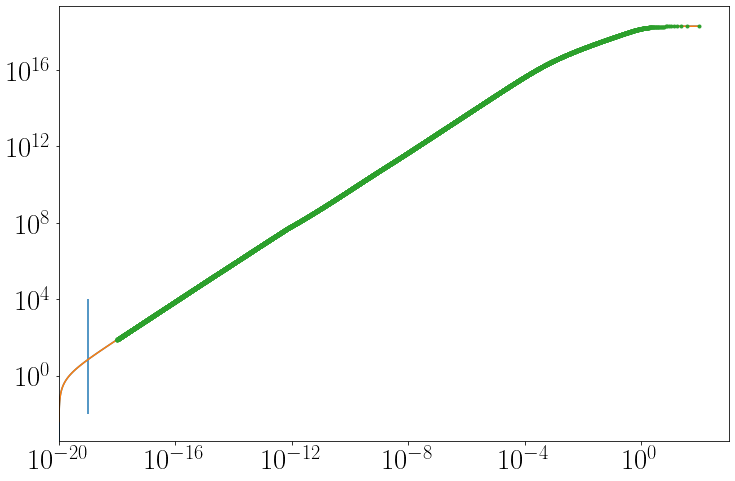

In [38]:
plt.figure(figsize=(12, 8))
plt.plot(a, eta)
plt.plot(a_n, etas_n)
plt.loglog()
plt.xlim(1e-20, 1e3)
plt.plot(a_good, eta_good, '.')

print(a[0])

plt.vlines(1e-19, 1e-2, 1e4)